In [1]:
import intake
from intake import cat
from xarray import DataTree, map_over_datasets

from dask.distributed import Client

import xarray as xr
import numpy as np
import cf_xarray as cfxr
import xesmf
import glob

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

In [2]:
import json
import pandas as pd
from pathlib import Path
from datetime import timedelta

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39073,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43551,Total threads: 1
Dashboard: /proxy/40471/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34461,


## Importing the data
Giving intake a chance for once, hope I don't regret it

In [4]:
#Choose which model we are working with
MODEL='cice5'
# MODEL='sis2'

Making a catalog for both access experiments (can skip because already done):

In [ ]:
import json
import pandas as pd
from pathlib import Path

# Paths to catalogs
control_json = Path('/home/272/kc5856/access_control_new.json')
melt_json = Path('/home/272/kc5856/access_meltwater_ssp126.json')
combined_json = Path('/home/272/kc5856/access_combined.json')
combined_csv = Path('/home/272/kc5856/access_combined.csv')

# Load both JSON files
with open(control_json, 'r') as f:
    control = json.load(f)

with open(melt_json, 'r') as f:
    melt = json.load(f)

# Remove 'file:' prefix if present
control_catalog_file = control["catalog_file"].replace("file:", "")
melt_catalog_file = melt["catalog_file"].replace("file:", "")

# Get absolute CSV paths
control_csv = Path(control_catalog_file)
melt_csv = Path(melt_catalog_file)

# Read both CSVs
df_control = pd.read_csv(control_csv)
df_melt = pd.read_csv(melt_csv)

# Add a column to identify source (optional but useful)
df_control["source"] = "control"
df_melt["source"] = "meltwater"

# Combine them
df_combined = pd.concat([df_control, df_melt], ignore_index=True)

# Save combined CSV
df_combined.to_csv(combined_csv, index=False)

# Create new JSON (copy from one and update catalog_file)
combined_metadata = control.copy()
combined_metadata["catalog_file"] = combined_csv.name  # relative path

# Save combined JSON
with open(combined_json, 'w') as f:
    json.dump(combined_metadata, f, indent=2)

print(f"✅ Combined catalog saved to {combined_json}")


In [5]:
catalog = intake.open_esm_datastore('/home/272/kc5856/access_combined.json', columns_with_iterables=['variable'])
catalog

,unique
filename,250
file_id,10
path,1442
filename_timestamp,241
frequency,3
start_date,242
end_date,241
variable,178
variable_long_name,11
variable_standard_name,9


In [6]:
# Defining variables

sic_args = {
    "cice5": {  # ACCESS-OM2 sea ice
        "sources": ["control", "meltwater"],  # matches 'source' column in catalog
        "variable": "aice_m",
        "decode_coords": False
    },
    "sis2": {  # MOM6 testing
        "sources": ["control", "meltwater"],  # or just ["control"] if only in control
        "variable": "siconc",
        "decode_coords": False
    }
}

area_variable = {
    "cice5": "area_t",
    "sis2": "areacello"
}

geo_variables = {
    "cice5": ['geolon_t', 'geolat_t'],
    "sis2": ['geolon', 'geolat']
}

In [7]:
# Get sources and variable from config
sources = sic_args[MODEL]['sources']         # e.g., ['control', 'meltwater']
variable = sic_args[MODEL]['variable']       # e.g., 'aice_m'

# Search catalog for these sources and variable
cat_subset = catalog.search(source=sources)  # filter by source
var_search = cat_subset.search(variable=variable, frequency="1mon")  # add variable and frequency filter

In [8]:
MODEL = "cice5"
variable = sic_args[MODEL]['variable']
decode_coords = sic_args[MODEL]['decode_coords']

# Control
cat_control = catalog.search(source="control", variable=variable, frequency="1mon")
dset_control = cat_control.to_dask(
    xarray_open_kwargs=dict(decode_coords=decode_coords, chunks=-1),
    xarray_combine_by_coords_kwargs=dict(compat="override", data_vars="minimal", coords="minimal")
)
sic_C = list(dset_control.values())[0]  # DataArray already

# Meltwater
cat_melt = catalog.search(source="meltwater", variable=variable, frequency="1mon")
dset_melt = cat_melt.to_dask(
    xarray_open_kwargs=dict(decode_coords=decode_coords, chunks=-1),
    xarray_combine_by_coords_kwargs=dict(compat="override", data_vars="minimal", coords="minimal")
)
sic_M = list(dset_melt.values())[0]  # DataArray already


In [9]:
sic_C

<xarray.DataArray 'aice_m' (time: 241, nj: 2700, ni: 3600)> Size: 9GB
dask.array<concatenate, shape=(241, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 1900-02-01 00:00:00 ... 1920-02-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [10]:
sic_M

<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)> Size: 5GB
dask.array<concatenate, shape=(120, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1910-02-01 00:00:00 ... 1920-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Another messy thing about CICE5 is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.

To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [11]:
if MODEL =='cice5' :
    sic_C['time'] = sic_C['time'].to_pandas() - timedelta(hours = 12)
    sic_M['time'] = sic_M['time'].to_pandas() - timedelta(hours = 12)

In [12]:
sic_C = sic_C.chunk({"time":11})
sic_C = sic_C.sel(time=slice("1910-01-01","1919-12-31"))

sic_M = sic_M.chunk({"time":11})
sic_M = sic_M.sel(time=slice("1910-01-01","1919-12-31"))

sic_C

<xarray.DataArray 'aice_m' (time: 120, nj: 2700, ni: 3600)> Size: 5GB
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(11, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1910-01-31 12:00:00 ... 1919-12-31 12:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [13]:
var_search = catalog.search(variable=area_variable[MODEL])

dset = var_search.to_dask()

# dset is a dict of DataArrays; pick the first one
area = list(dset.values())[0].load()

area

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point

In [14]:
## Corrected area

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

# Import a variable 
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))

def preprocess(ds):
    ds = ds['salt']
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')

var = cont['salt'].isel(time=0,st_ocean=0)

area_corr = area*(var*0 +1)

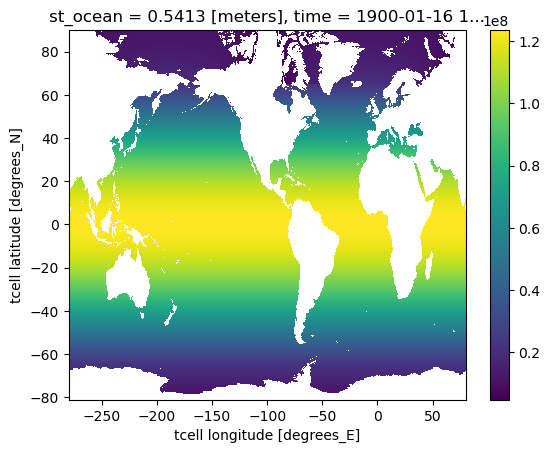

In [15]:
area_corr.plot()

In [16]:
if MODEL == 'cice5':
    # For control
    sic_C = sic_C.assign_coords(
        ni=("ni", area_corr['xt_ocean'].values),
        nj=("nj", area_corr['yt_ocean'].values)
    )
    sic_C['ni'].attrs = area_corr['xt_ocean'].attrs
    sic_C['nj'].attrs = area_corr['yt_ocean'].attrs
    sic_C = sic_C.rename({'ni': 'xt_ocean', 'nj': 'yt_ocean'})

    # For meltwater
    sic_M = sic_M.assign_coords(
        ni=("ni", area_corr['xt_ocean'].values),
        nj=("nj", area_corr['yt_ocean'].values)
    )
    sic_M['ni'].attrs = area_corr['xt_ocean'].attrs
    sic_M['nj'].attrs = area_corr['yt_ocean'].attrs
    sic_M = sic_M.rename({'ni': 'xt_ocean', 'nj': 'yt_ocean'})

In [17]:
sic_C

<xarray.DataArray 'aice_m' (time: 120, yt_ocean: 2700, xt_ocean: 3600)> Size: 5GB
dask.array<getitem, shape=(120, 2700, 3600), dtype=float32, chunksize=(11, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1910-01-31 12:00:00 ... 1919-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Sea Ice Area

Let's look at a timeseries of SO sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. We also need to drop geolon and geolat so we have unique longitude and latitude to reference

#### Time series on shelf

In [64]:
## Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [65]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [71]:
# Apply mask and multiply by area for control
# Mask SIC < 0.15
sic_C = sic_C.where(sic_C >= 0.15)
sic_M = sic_M.where(sic_M >= 0.15)

# Apply shelf mask and compute sea ice area
si_area_C = sic_C.where(shelf_mask == 1) * area_corr
si_area_M = sic_M.where(shelf_mask == 1) * area_corr

if MODEL == 'cice5':
    si_area_C = si_area_C.drop_vars({'geolon_t', 'geolat_t'})
    si_area_M = si_area_M.drop_vars({'geolon_t', 'geolat_t'})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


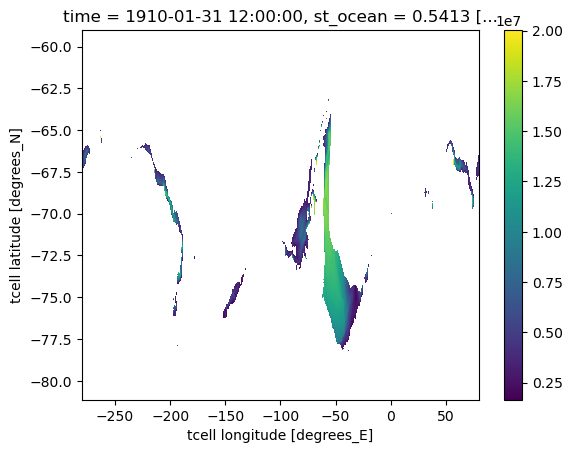

In [73]:
si_area_C.isel(time=0).plot()

In [75]:
# Sum over region (south of 40°S)
sic_C_SH_shelf_area = si_area_C.sel(yt_ocean=slice(None, -40)).sum(['xt_ocean', 'yt_ocean'])
sic_M_SH_shelf_area = si_area_M.sel(yt_ocean=slice(None, -40)).sum(['xt_ocean', 'yt_ocean'])
sic_C_SH_shelf_area

<xarray.DataArray (time: 120)> Size: 480B
dask.array<sum-aggregate, shape=(120,), dtype=float32, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1910-01-31 12:00:00 ... 1919-12-31 12:00:00
    st_ocean  float64 8B 0.5413

In [76]:
sic_C_SH_shelf_area = sic_C_SH_shelf_area.load()

In [77]:
sic_M_SH_shelf_area = sic_M_SH_shelf_area.load()

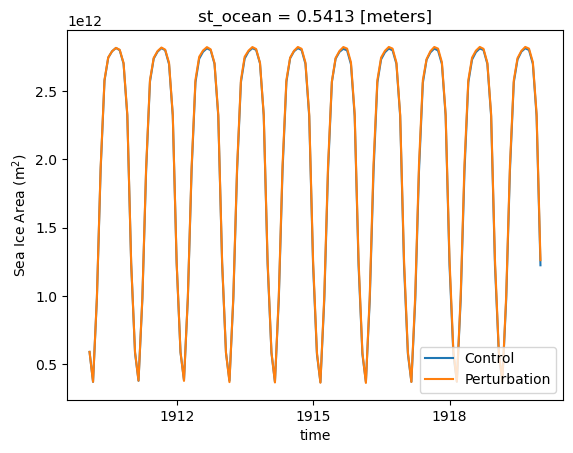

In [78]:
sic_C_SH_shelf_area.plot(label = 'Control')
sic_M_SH_shelf_area.plot(label = 'Perturbation')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (m$^{2}$)');

In [82]:
sic_area_anom = sic_M_SH_shelf_area - sic_C_SH_shelf_area
sic_area_anom = sic_area_anom.load()

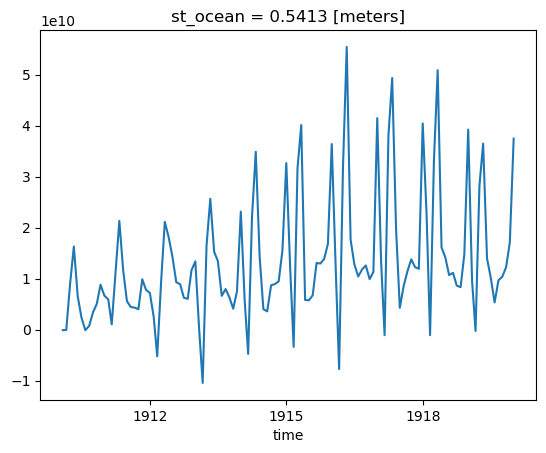

In [83]:
sic_area_anom.plot()

In [84]:
sic_area_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_shelf_anom_access.nc')

#### Checking the seasonal cycle

Text(0, 0.5, 'Sea Ice Area (m$^{2}$)')

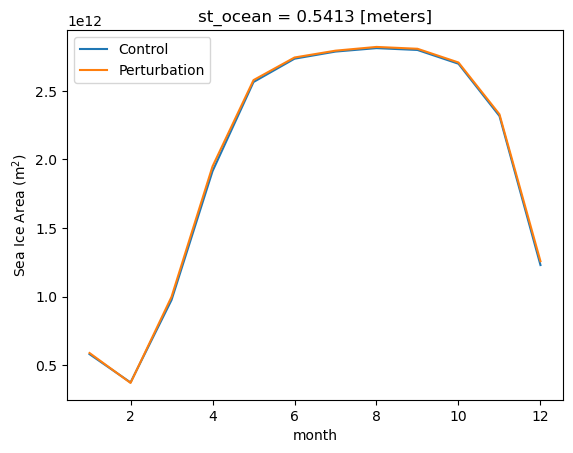

In [79]:
sic_C_SH_shelf_area.groupby('time.month').mean('time').plot(label='Control')
sic_M_SH_shelf_area.groupby('time.month').mean('time').plot(label='Perturbation')

plt.legend()
plt.ylabel('Sea Ice Area (m$^{2}$)')

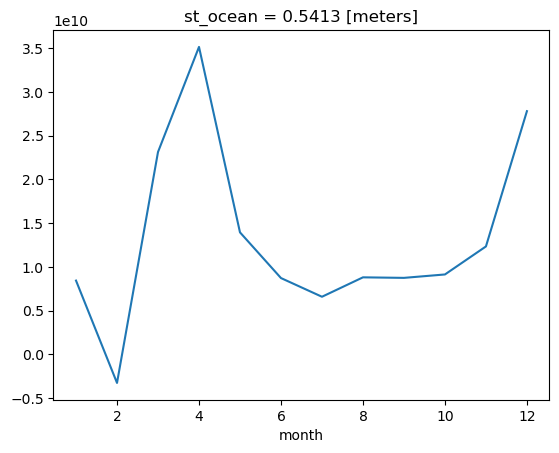

In [80]:
season_C = sic_C_SH_shelf_area.groupby('time.month').mean('time')
season_M = sic_M_SH_shelf_area.groupby('time.month').mean('time')

season_anom = season_M - season_C

season_anom.plot()

## Mapping

In [27]:
sic_C

<xarray.DataArray 'aice_m' (time: 120, yt_ocean: 2700, xt_ocean: 3600)> Size: 5GB
dask.array<where, shape=(120, 2700, 3600), dtype=float32, chunksize=(11, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1910-01-31 12:00:00 ... 1919-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [58]:
sic_C_map = sic_C.sel(yt_ocean=slice(None, -40)).sel(time=slice("1915-01-01","1919-12-31")).mean(dim='time')
sic_M_map = sic_M.sel(yt_ocean=slice(None, -40)).sel(time=slice("1915-01-01","1919-12-31")).mean(dim='time')

In [59]:
sic_C_map_n = sic_C_map.fillna(0)
sic_M_map_n = sic_M_map.fillna(0)

In [60]:
sic_C_map_n

<xarray.DataArray 'aice_m' (yt_ocean: 808, xt_ocean: 3600)> Size: 12MB
dask.array<where, shape=(808, 3600), dtype=float32, chunksize=(808, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 6kB -81.11 -81.07 -81.02 ... -40.11 -40.03

In [61]:
sic_C_map_n = sic_C_map_n.load()

In [62]:
sic_M_map_n = sic_M_map_n.load()

In [63]:
sic_map_anom = sic_M_map_n - sic_C_map_n
sic_map_anom = sic_map_anom.load()

In [66]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

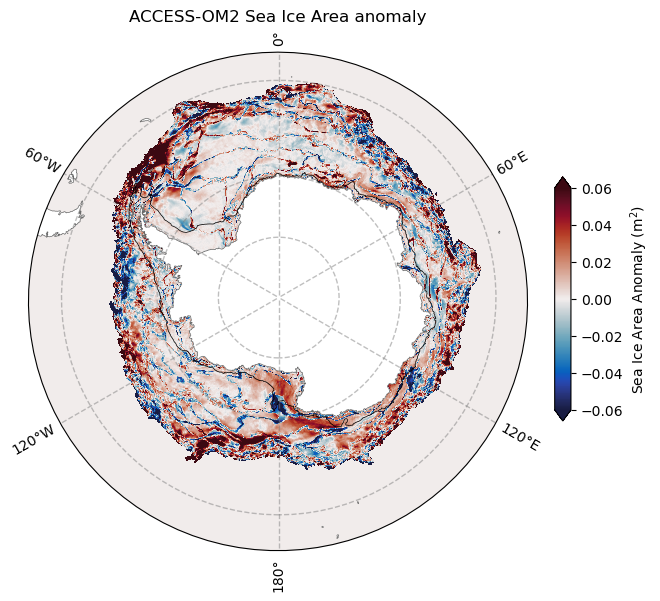

In [67]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

sic_map_anom.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Ice Area Anomaly (m$^{2}$)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2 Sea Ice Area anomaly");